<a href="https://colab.research.google.com/github/malcolmrite-dsi/CPT-House-Predictions/blob/master/Data_Cleaning_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#Importing One Hot Encoding libraries
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.impute import SimpleImputer

# Importing the Datasets

## Property 24 Dataset

In [3]:
p24_df = pd.read_csv("drive/My Drive/cpt-houseprices_p24.csv")
p24_df.head()

,Description,Suburb,Price
0,1 Bedroom Apartment,Muizenberg,R 3 500 000
1,Commercial Property,De Waterkant,R 1 845 000
2,House,Gardens,R 1 895 000
3,Commercial Property,Kirstenhof,R 12 000 000
4,4 Bedroom House,Cape Town City Centre,R 995 000


## RE/MAX Properties Dataset

In [4]:
remax_df = pd.read_csv("drive/My Drive/cpt-houseprices_remax.csv")
remax_df.head()

,Description,Price
0,5 Bedroom House in Belgravia,R1 790 000
1,3 Bedroom Townhouse in Kenilworth,R2 775 000
2,4 Bedroom House in Ferness Estate,R2 700 000
3,4 Bedroom House in Sybrand Park,R2 600 000
4,3 Bedroom House in Coniston Park,R1 495 000


## Private Property Dataset

In [5]:
priv_df = pd.read_csv("drive/My Drive/cpt-houseprices_priv_prop.csv")
priv_df.head()

,Description,Suburb,Price
0,Agents in this Area,Sea Point,R 4 950 000
1,Atlantic Seaboard,Camps Bay,R 13 950 000
2,Suburb Specialist,Green Point,R 11 900 000
3,2 Bed House in Sea Point,Waterfront,R 8 500 000
4,4 Bed House in Camps Bay,Bantry Bay,R 3 500 000


In [6]:
priv_df.Price.value_counts()

Sold            397
R 2 495 000      82
R 1 350 000      79
R 2 995 000      67
R 1 850 000      64
               ... 
R 3 449 999       1
R 1 565 000       1
R 13 845 000      1
R 1 260 000       1
R 4 599 999       1
Name: Price, Length: 1035, dtype: int64

## City Suburbs Dataset

In [7]:
city_df = pd.read_csv("drive/My Drive/cpt-suburbs_finished.csv")
city_df.head()

,Suburb,Income
0,Bakoven,3
1,Bantry Bay,3
2,Camps Bay,3
3,Clifton,3
4,Fresnaye,3


# Feature Engineering

## Feature Engineering Functions

Incorporate the city suburb data set and apply the income level to them.

In [8]:
def suburbSelection(df, city_data):
  income = []
  suburbs = {}
  for i, burb in enumerate(city_data.Suburb):
    suburbs[burb] = city_data.Income.iloc[i]
    print()
  for i, location in enumerate(df.Suburb):
    if location in suburbs:
      income.append(suburbs[location])
    else:
      income.append(2)
      df.Suburb.iloc[i] =  "Other"

  df.insert(loc = 2, column = "Income", value = income)
  return df

Delete prices with sold or POA

In [9]:
def deletePOA(df):
  for i, price in enumerate(df.Price.sum()):
    if price == "Sold" or price == "POA":
      df.drop(i, inplace = True)
    
  return df

Generating bathroom features and house type features

In [10]:
def featureGeneration(df):
  Bedrooms = []
  HouseType = []
  
  for i, descr in enumerate(df["Description"]):
    if descr == "" or len(descr) <= 5:
      df.drop(i, inplace = True)
      continue
    else:
      desc = str(descr).split()
      if not desc:
        df.drop(i, inplace = True)
      elif desc[0].isdigit():
        Bedrooms.append(desc[0]) 
        HouseType.append(desc[-1])
      else:
        df.drop(i, inplace = True)
  
  df.insert(loc = 1, column = "Bedrooms", value = Bedrooms)
  df.insert(loc = 2, column = "HouseType", value = HouseType)
  return df

Generating a suburb feature for the datasets without the suburb feature

In [11]:
def suburbGenerator(df):
  Suburbs = []
  for i, descr in enumerate(df["Description"]):
    stop = 0
    desc = str(descr).split()
    flag = 0
    burb = []
    for dCount, charac in enumerate(desc):
      if charac == "in":
        flag = 1
        stop = dCount
        continue
      if flag == 1:
        burb.append(charac) 

    df["Description"].iloc[i] = ' '.join([str(elem) for elem in desc[:stop]])
    Suburbs.append(' '.join([str(elem) for elem in burb]))

  df.insert(loc = 1, column = "Suburb", value = Suburbs)

  return df

Removing the suburb from the description feature to utilise the feature generation.

In [12]:
def suburbRemover(df):
  Suburbs = []
  for i, descr in enumerate(df["Description"]):
    stop = 0
    desc = str(descr).split()
    flag = 0
    burb = []
    for dCount, charac in enumerate(desc):
      if charac == "in":
        flag = 1
        stop = dCount
        continue
      if flag == 1:
        burb.append(charac) 

    df["Description"].iloc[i] = ' '.join([str(elem) for elem in desc[:stop]])

  return df

## Applying Feature Engineering Functions

Dropping any records where the price is not stated.

In [13]:
priv_df = deletePOA(priv_df)
priv_df.describe()

,Description,Suburb,Price
count,6420,6420,6420
unique,1519,221,1035
top,Agents in this Area,Sea Point,Sold
freq,428,287,397


In [14]:
remax_df = deletePOA(remax_df)
remax_df.describe()

,Description,Price
count,1200,1200
unique,420,466
top,2 Bedroom Apartment / Flat in Sea Point,R1 995 000
freq,51,19


Applying the Suburb Generator Function. Which extracts the neighborhood from the Description feature. This Feature would help the model

In [15]:
remax_df = suburbGenerator(remax_df)
remax_df.head()

,Description,Suburb,Price
0,5 Bedroom House,Belgravia,R1 790 000
1,3 Bedroom Townhouse,Kenilworth,R2 775 000
2,4 Bedroom House,Ferness Estate,R2 700 000
3,4 Bedroom House,Sybrand Park,R2 600 000
4,3 Bedroom House,Coniston Park,R1 495 000


In [16]:
p24_df = suburbSelection(p24_df, city_df)
p24_df.head()

,Description,Suburb,Income,Price
0,1 Bedroom Apartment,Muizenberg,2,R 3 500 000
1,Commercial Property,De Waterkant,2,R 1 845 000
2,House,Gardens,2,R 1 895 000
3,Commercial Property,Kirstenhof,2,R 12 000 000
4,4 Bedroom House,Other,2,R 995 000


In [17]:
priv_df = suburbSelection(priv_df, city_df)
priv_df.head()

,Description,Suburb,Income,Price
0,Agents in this Area,Sea Point,3,R 4 950 000
1,Atlantic Seaboard,Camps Bay,3,R 13 950 000
2,Suburb Specialist,Green Point,3,R 11 900 000
3,2 Bed House in Sea Point,Other,2,R 8 500 000
4,4 Bed House in Camps Bay,Bantry Bay,3,R 3 500 000


In [18]:
remax_df = suburbSelection(remax_df, city_df)
remax_df.head()

,Description,Suburb,Income,Price
0,5 Bedroom House,Other,2,R1 790 000
1,3 Bedroom Townhouse,Kenilworth,2,R2 775 000
2,4 Bedroom House,Other,2,R2 700 000
3,4 Bedroom House,Other,2,R2 600 000
4,3 Bedroom House,Other,2,R1 495 000


Applying the suburb remover function. Which removes the suburb from the description.

In [19]:
priv_df = suburbRemover(priv_df)
priv_df.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,Description,Suburb,Income,Price
0,Agents,Sea Point,3,R 4 950 000
1,,Camps Bay,3,R 13 950 000
2,,Green Point,3,R 11 900 000
3,2 Bed House,Other,2,R 8 500 000
4,4 Bed House,Bantry Bay,3,R 3 500 000


In [20]:
p24_df.Suburb.value_counts()

Other           340
Sea Point       128
Green Point      68
Observatory      52
Rondebosch       51
               ... 
Ndabeni           1
Bakoven           1
Steenberg         1
Kreupelbosch      1
St James          1
Name: Suburb, Length: 71, dtype: int64

Applying the feature generation function, which creates to new categories from the descrition. House Type, and Number of Bedrooms. This should help the model.

In [21]:
priv_df = featureGeneration(priv_df)
priv_df.head()

,Description,Bedrooms,HouseType,Suburb,Income,Price
3,2 Bed House,2,House,Other,2,R 8 500 000
4,4 Bed House,4,House,Bantry Bay,3,R 3 500 000
5,5 Bed House,5,House,Sea Point,3,R 15 999 000
6,1 Bed Apartment,1,Apartment,Other,2,R 12 995 000
7,2 Bed Apartment,2,Apartment,Sea Point,3,R 1 525 000


In [22]:
p24_df.head()

,Description,Suburb,Income,Price
0,1 Bedroom Apartment,Muizenberg,2,R 3 500 000
1,Commercial Property,De Waterkant,2,R 1 845 000
2,House,Gardens,2,R 1 895 000
3,Commercial Property,Kirstenhof,2,R 12 000 000
4,4 Bedroom House,Other,2,R 995 000


In [23]:
p24_df = featureGeneration(p24_df)
p24_df.head()

,Description,Bedrooms,HouseType,Suburb,Income,Price
0,1 Bedroom Apartment,1,Apartment,Muizenberg,2,R 3 500 000
4,4 Bedroom House,4,House,Other,2,R 995 000
6,2 Bedroom House,2,House,Rondebosch,2,R 2 395 000
7,4 Bedroom House,4,House,Claremont,2,R 19 950 000
8,1 Bedroom Apartment,1,Apartment,Constantia,2,R 795 000


In [24]:
remax_df = featureGeneration(remax_df)
remax_df.head()

,Description,Bedrooms,HouseType,Suburb,Income,Price
0,5 Bedroom House,5,House,Other,2,R1 790 000
1,3 Bedroom Townhouse,3,Townhouse,Kenilworth,2,R2 775 000
2,4 Bedroom House,4,House,Other,2,R2 700 000
3,4 Bedroom House,4,House,Other,2,R2 600 000
4,3 Bedroom House,3,House,Other,2,R1 495 000


In [25]:
priv_df.describe()

,Income
count,5141.000000
mean,2.063023
std,0.354949
min,1.000000
25%,2.000000
50%,2.000000
75%,2.000000
max,3.000000


In [26]:
priv_df.Price.value_counts()

Sold           317
R 2 495 000     68
R 1 350 000     67
R 2 995 000     57
R 1 850 000     53
              ... 
R 1 995 002      1
R 2 440 000      1
R 3 525 000      1
R 2 245 000      1
R 815 000        1
Name: Price, Length: 948, dtype: int64

In [27]:
priv_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5141 entries, 3 to 6419
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Description  5141 non-null   object
 1   Bedrooms     5141 non-null   object
 2   HouseType    5141 non-null   object
 3   Suburb       5141 non-null   object
 4   Income       5141 non-null   int64 
 5   Price        5141 non-null   object
dtypes: int64(1), object(5)
memory usage: 281.1+ KB


## Dropping Columns

In [28]:
p24_df.drop("Description", axis = 1, inplace=True)
p24_df.head()

,Bedrooms,HouseType,Suburb,Income,Price
0,1,Apartment,Muizenberg,2,R 3 500 000
4,4,House,Other,2,R 995 000
6,2,House,Rondebosch,2,R 2 395 000
7,4,House,Claremont,2,R 19 950 000
8,1,Apartment,Constantia,2,R 795 000


In [29]:
remax_df.drop("Description", axis = 1, inplace=True)
remax_df.head()

,Bedrooms,HouseType,Suburb,Income,Price
0,5,House,Other,2,R1 790 000
1,3,Townhouse,Kenilworth,2,R2 775 000
2,4,House,Other,2,R2 700 000
3,4,House,Other,2,R2 600 000
4,3,House,Other,2,R1 495 000


In [30]:
priv_df.drop("Description", axis = 1, inplace=True)
priv_df.head()

,Bedrooms,HouseType,Suburb,Income,Price
3,2,House,Other,2,R 8 500 000
4,4,House,Bantry Bay,3,R 3 500 000
5,5,House,Sea Point,3,R 15 999 000
6,1,Apartment,Other,2,R 12 995 000
7,2,Apartment,Sea Point,3,R 1 525 000


In [31]:
priv_df.HouseType.value_counts()

House        2971
Apartment    1802
Townhouse     259
Duplex         50
Flat           40
Cluster        10
Penthouse       8
Simplex         1
Name: HouseType, dtype: int64

In [32]:
remax_df.replace("Flat", "Apartment", inplace = True)

In [33]:
priv_df.replace("Flat", "Apartment", inplace = True)
priv_df.replace("Penthouse", "Apartment", inplace = True)
priv_df.replace("Duplex", "Townhouse", inplace = True)
priv_df.replace("Simplex", "Townhouse", inplace = True)
priv_df.replace("Cluster", "Townhouse", inplace = True)



# Data Type Changes

In [34]:
def fixPrice(df):
  
  for i, price in enumerate(df["Price"]):
    numbers = []
    for character in str(price).split():
      if character.isdigit():
        numbers.append(character)
      

    df["Price"].iloc[i] = (''.join([str(elem) for elem in numbers]))
  
  return df

In [35]:
def catDataType(data):
  for feature in data.columns:
    if data[feature].dtype == "object":
      data[feature] = data[feature].astype('category')

  return data

## Fixing the Price Feature

In [36]:
p24_df = fixPrice(p24_df)
p24_df.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,Bedrooms,HouseType,Suburb,Income,Price
0,1,Apartment,Muizenberg,2,3500000
4,4,House,Other,2,995000
6,2,House,Rondebosch,2,2395000
7,4,House,Claremont,2,19950000
8,1,Apartment,Constantia,2,795000


In [37]:
remax_df = fixPrice(remax_df)
remax_df.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,Bedrooms,HouseType,Suburb,Income,Price
0,5,House,Other,2,790000
1,3,Townhouse,Kenilworth,2,775000
2,4,House,Other,2,700000
3,4,House,Other,2,600000
4,3,House,Other,2,495000


In [38]:
priv_df = fixPrice(priv_df)
priv_df.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,Bedrooms,HouseType,Suburb,Income,Price
3,2,House,Other,2,8500000
4,4,House,Bantry Bay,3,3500000
5,5,House,Sea Point,3,15999000
6,1,Apartment,Other,2,12995000
7,2,Apartment,Sea Point,3,1525000


In [39]:
priv_df.describe()

,Income
count,5141.000000
mean,2.063023
std,0.354949
min,1.000000
25%,2.000000
50%,2.000000
75%,2.000000
max,3.000000


## Replacing Blank Price Values

In [40]:
p24_df.Price = p24_df.Price.replace('',None)
remax_df.Price = remax_df.Price.replace('',None)
priv_df.Price = priv_df.Price.replace('',None)

In [41]:
priv_df.describe()

,Income
count,5141.000000
mean,2.063023
std,0.354949
min,1.000000
25%,2.000000
50%,2.000000
75%,2.000000
max,3.000000


## Changing Data Types 

In [42]:
p24_df.Price = p24_df.Price.astype(float)
p24_df.Bedrooms = p24_df.Bedrooms.astype(int)
p24_df.head()

,Bedrooms,HouseType,Suburb,Income,Price
0,1,Apartment,Muizenberg,2,3500000.0
4,4,House,Other,2,995000.0
6,2,House,Rondebosch,2,2395000.0
7,4,House,Claremont,2,19950000.0
8,1,Apartment,Constantia,2,795000.0


In [43]:
remax_df.Price = remax_df.Price.astype(float)
remax_df.Bedrooms = remax_df.Bedrooms.astype(int)
remax_df.head()

,Bedrooms,HouseType,Suburb,Income,Price
0,5,House,Other,2,790000.0
1,3,Townhouse,Kenilworth,2,775000.0
2,4,House,Other,2,700000.0
3,4,House,Other,2,600000.0
4,3,House,Other,2,495000.0


In [44]:
priv_df.Price = priv_df.Price.astype(float)
priv_df.Bedrooms = priv_df.Bedrooms.astype(int)
priv_df.head()

,Bedrooms,HouseType,Suburb,Income,Price
3,2,House,Other,2,8500000.0
4,4,House,Bantry Bay,3,3500000.0
5,5,House,Sea Point,3,15999000.0
6,1,Apartment,Other,2,12995000.0
7,2,Apartment,Sea Point,3,1525000.0


In [45]:
priv_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5141 entries, 3 to 6419
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Bedrooms   5141 non-null   int64  
 1   HouseType  5141 non-null   object 
 2   Suburb     5141 non-null   object 
 3   Income     5141 non-null   int64  
 4   Price      5141 non-null   float64
dtypes: float64(1), int64(2), object(2)
memory usage: 241.0+ KB


## Change Objects to Categorical Data

In [46]:
p24_df = catDataType(p24_df)

In [47]:
remax_df = catDataType(remax_df)

In [48]:
remax_df.HouseType.value_counts()

Apartment    597
House        566
Townhouse     37
Name: HouseType, dtype: int64

In [49]:
priv_df = catDataType(priv_df)

In [50]:
priv_df.HouseType.value_counts()

House        2971
Apartment    1850
Townhouse     320
Name: HouseType, dtype: int64

# Missing Data Code

In [51]:
#Check Missing Values in a Dataset
def NACount(data):
  NaCount = {}
  for feature in data.columns:
    NaCount[feature] = data[feature].isna().sum()

  return NaCount

In [52]:
#Check Unique Values in Training Data
def UniqueCount(data):
  UnCount = {}
  for feature in data.columns:
    UnCount[feature] = data[feature].unique()

  return UnCount

In [53]:
print(NACount(remax_df))

{'Bedrooms': 0, 'HouseType': 0, 'Suburb': 0, 'Income': 0, 'Price': 0}


In [54]:
print(UniqueCount(priv_df))

{'Bedrooms': array([ 2,  4,  5,  1,  3,  6,  8,  7, 30, 13,  9, 15, 11, 18, 10, 90, 12,
       14, 16]), 'HouseType': [House, Apartment, Townhouse]
Categories (3, object): [House, Apartment, Townhouse], 'Suburb': [Other, Bantry Bay, Sea Point, Fresnaye, Foreshore, ..., Mowbray, Crawford, Bloubergstrand, Parklands, West Beach]
Length: 83
Categories (83, object): [Other, Bantry Bay, Sea Point, Fresnaye, ..., Crawford, Bloubergstrand,
                          Parklands, West Beach], 'Income': array([2, 3, 1]), 'Price': array([ 8500000.,  3500000., 15999000., 12995000.,  1525000.,  5495000.,
        2350000.,  2800000., 23000000., 19995000., 55000000.,  1995000.,
        8995000., 13750000.,  1350000.,  1750000.,  5995000.,  3191550.,
        4038000.,  6995000.,  3599000., 39950000., 26995000.,  1595000.,
        3299000., 23500000., 10695000.,  3750000.,  4200000.,  1950000.,
        1550000.,  3895000.,  2100000.,  4195000.,  4795000., 12499000.,
       18380000.,  4850000., 11900000.,

## Replace 0 Values of Price with Website Mean

In [55]:
remax_df.Price.value_counts()

0.0         136
995000.0     89
500000.0     79
950000.0     73
250000.0     53
           ... 
249000.0      1
285000.0      1
997000.0      1
349000.0      1
245000.0      1
Name: Price, Length: 125, dtype: int64

In [56]:
my_imputer = SimpleImputer(missing_values = 0, strategy = 'constant', fill_value=1395000)

# Fill in the lines below: imputation
imputed_X_train = pd.DataFrame(my_imputer.fit_transform(remax_df.iloc[:,[3]]))

#Fill in the lines below: imputation removed column names; put them back
imputed_X_train.columns = remax_df.iloc[:,[3]].columns

remax_df.iloc[:,[3]] = imputed_X_train

remax_df.head()

,Bedrooms,HouseType,Suburb,Income,Price
0,5,House,Other,2,790000.0
1,3,Townhouse,Kenilworth,2,775000.0
2,4,House,Other,2,700000.0
3,4,House,Other,2,600000.0
4,3,House,Other,2,495000.0


In [57]:
'''my_imputer = SimpleImputer(missing_values = 0, strategy = 'mean', add_indicator=True)

# Fill in the lines below: imputation
imputed_X_train = pd.DataFrame(my_imputer.fit_transform(priv_df.iloc[:,[3]]))

#Fill in the lines below: imputation removed column names; put them back
imputed_X_train.columns = priv_df.iloc[:,[3]].columns

priv_df.iloc[:,[3]] = imputed_X_train

priv_df.head()'''

"my_imputer = SimpleImputer(missing_values = 0, strategy = 'mean', add_indicator=True)\n\n# Fill in the lines below: imputation\nimputed_X_train = pd.DataFrame(my_imputer.fit_transform(priv_df.iloc[:,[3]]))\n\n#Fill in the lines below: imputation removed column names; put them back\nimputed_X_train.columns = priv_df.iloc[:,[3]].columns\n\npriv_df.iloc[:,[3]] = imputed_X_train\n\npriv_df.head()"

# Data Exploration

In [58]:
priv_df.head()

,Bedrooms,HouseType,Suburb,Income,Price
3,2,House,Other,2,8500000.0
4,4,House,Bantry Bay,3,3500000.0
5,5,House,Sea Point,3,15999000.0
6,1,Apartment,Other,2,12995000.0
7,2,Apartment,Sea Point,3,1525000.0


In [59]:
priv_df.Price.describe()

count    5.141000e+03
mean     3.868006e+06
std      5.089001e+06
min      2.100000e+05
25%      1.499000e+06
50%      2.400000e+06
75%      3.950000e+06
max      7.500000e+07
Name: Price, dtype: float64

## Exploratory Data Analysis Function

In [60]:
#Defining graphing function
def ExploreGraphs(x_feature, y_result, df, choice, custom):
  
  #Setting the visual features of the graph
  sns.set_style("darkgrid")
  plt.figure(figsize=(20,10))
  
  #Bar Chart choice
  if choice == "bar":

    barplot = sns.barplot(x = x_feature, y = y_result, data = df, ci=custom)
    plt.xticks(rotation=90)
    plt.show()

  #Boxplot Choice
  elif choice == "box":

    boxplot = sns.boxplot(x= x_feature, y = y_result, data = df, hue = custom)
    plt.xticks(rotation=90)
    plt.show()

  #Histogram choice
  elif choice == "hist":

    histplot = sns.distplot(df[x_feature])
    plt.show()

  #Count Plot Choice
  elif choice == "count":

    barplot = sns.countplot(x = x_feature, data = df)
    plt.show()

  #Heat map choice
  elif choice == "heat":

    plt.figure(figsize=(30,30))
    sns.heatmap(df.corr(), vmax=0.8, square=True, annot = True)

  #Pair plot choice
  elif choice == "pair":

    sns.pairplot(df)

  #In case the choice input is not defined in the function
  else:
    print("Not a valid choice")

## Graphing Area

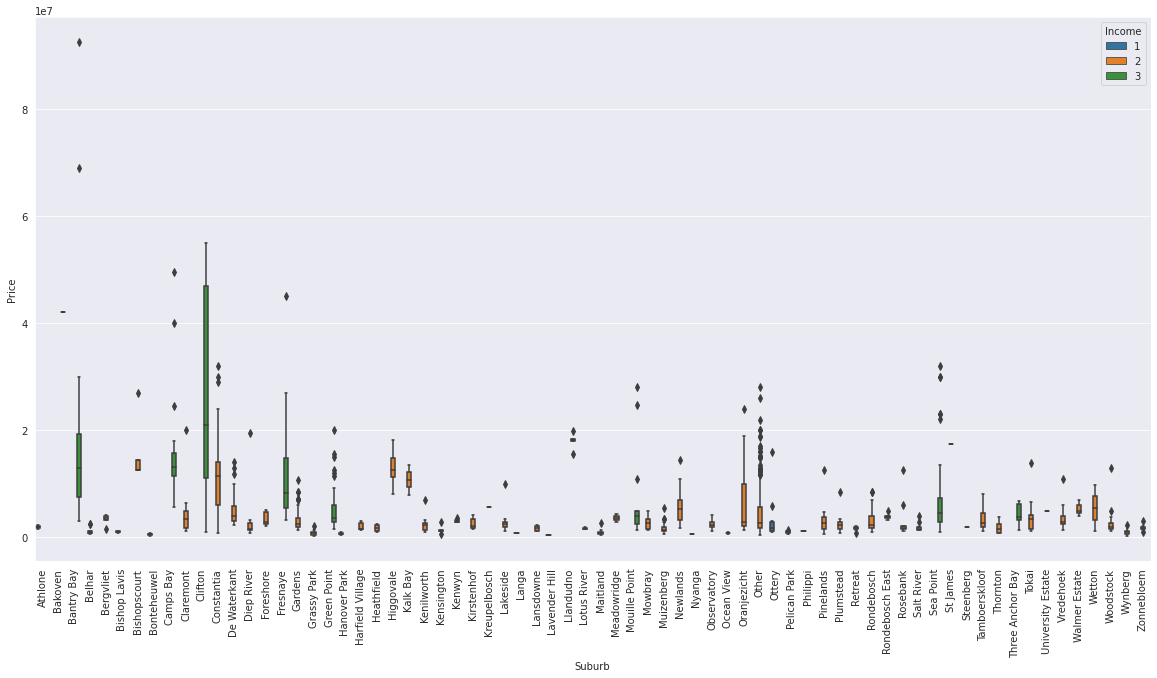

In [61]:
'''
How to use function
FIRST PARAMETER: X Feature (Pandas Column Name)

SECOND PARAMETER: Y FEATURE (Pandas Column Name)

THIRD PARAMETER: DATA (Pandas Dataframe)

FOURTH PARAMETER: Choice of graph: "bar" for Bar Plot (Good for comparing one numeric feature with a feature),
                                    "box" for Box Plot (Good for comparing one insurance product with a feature),
                                    "hist" for Histogram (Good for continuous distrbution of one feature),
                                    "count" for a count plot (Good for the discontinuous distribution of one feature),
                                    "heat" for a heatmap between the variables of the dataset,
                                    "pair" for a pairplot between the variables of a dataset (Be careful of the number of features you're comparing)

FIFTH PARAMETER: Confidence Interval error bar for Bar Plot = number (number% Confidence Interval), None (No error bar) 
'''
ExploreGraphs("Suburb", "Price", p24_df, "box", "Income")

# Encoding the Data

In [62]:
property_dataset = pd.merge(p24_df, remax_df, how = "outer")
property_dataset = pd.merge(property_dataset, priv_df, how = "outer")
property_dataset

,Bedrooms,HouseType,Suburb,Income,Price
0,1,Apartment,Muizenberg,2,3500000.0
1,4,House,Other,2,995000.0
2,4,House,Other,2,995000.0
3,2,House,Rondebosch,2,2395000.0
4,4,House,Claremont,2,19950000.0
...,...,...,...,...,...
7448,4,House,Other,2,2595000.0
7449,2,Apartment,Other,2,2745000.0
7450,3,House,Parklands,2,2850000.0
7451,4,House,Other,2,2059000.0


In [63]:
property_dataset.Price.value_counts()

0.0          136
995000.0     119
950000.0     111
2495000.0     91
1350000.0     86
            ... 
749900.0       1
2278800.0      1
2575000.0      1
210000.0       1
972900.0       1
Name: Price, Length: 1059, dtype: int64

In [64]:
# label_encoder object knows how to understand word labels. 
label_encoder = preprocessing.LabelEncoder() 
  
# Encode labels in column 'species'. 
property_dataset.Suburb = label_encoder.fit_transform(property_dataset.Suburb) 

In [65]:
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(sparse=False), [1])], remainder='passthrough')
property_dataset = (ct.fit_transform(property_dataset))
property_dataset

array([[1.000e+00, 0.000e+00, 0.000e+00, ..., 5.800e+01, 2.000e+00,
        3.500e+06],
       [0.000e+00, 1.000e+00, 0.000e+00, ..., 6.500e+01, 2.000e+00,
        9.950e+05],
       [0.000e+00, 1.000e+00, 0.000e+00, ..., 6.500e+01, 2.000e+00,
        9.950e+05],
       ...,
       [0.000e+00, 1.000e+00, 0.000e+00, ..., 6.800e+01, 2.000e+00,
        2.850e+06],
       [0.000e+00, 1.000e+00, 0.000e+00, ..., 6.500e+01, 2.000e+00,
        2.059e+06],
       [0.000e+00, 1.000e+00, 0.000e+00, ..., 6.800e+01, 2.000e+00,
        1.395e+06]])

In [66]:
from sklearn.model_selection import train_test_split
X_train_80, X_valid_20, Y_train_80, Y_valid_20 = train_test_split(property_dataset[:,:-1], property_dataset[:,-1], test_size = 0.2, random_state=1)

In [67]:
X_train_80

array([[ 1.,  0.,  0.,  2., 65.,  2.],
       [ 0.,  1.,  0.,  3., 65.,  2.],
       [ 0.,  1.,  0.,  3., 65.,  2.],
       ...,
       [ 0.,  1.,  0.,  3., 71.,  1.],
       [ 1.,  0.,  0.,  2., 65.,  2.],
       [ 1.,  0.,  0.,  1., 21.,  2.]])

In [68]:

np.savetxt("drive/My Drive/v1_X_train_80.csv", X_train_80, delimiter=',')
np.savetxt("drive/My Drive/v1_X_test_20.csv", X_valid_20, delimiter=',')
np.savetxt("drive/My Drive/v1_Y_train_80.csv", Y_train_80, delimiter=',')
np.savetxt("drive/My Drive/v1_Y_test_20.csv", Y_valid_20, delimiter=',')